Prediction Metrics (Test Set):
RMSE: 0.4107, MSE: 0.1687, MAE: 0.2212, MAPE: 0.33%

Forecast Metrics (Test Period):
RMSE: 0.7042, MSE: 0.4959, MAE: 0.5885, MAPE: 0.61%


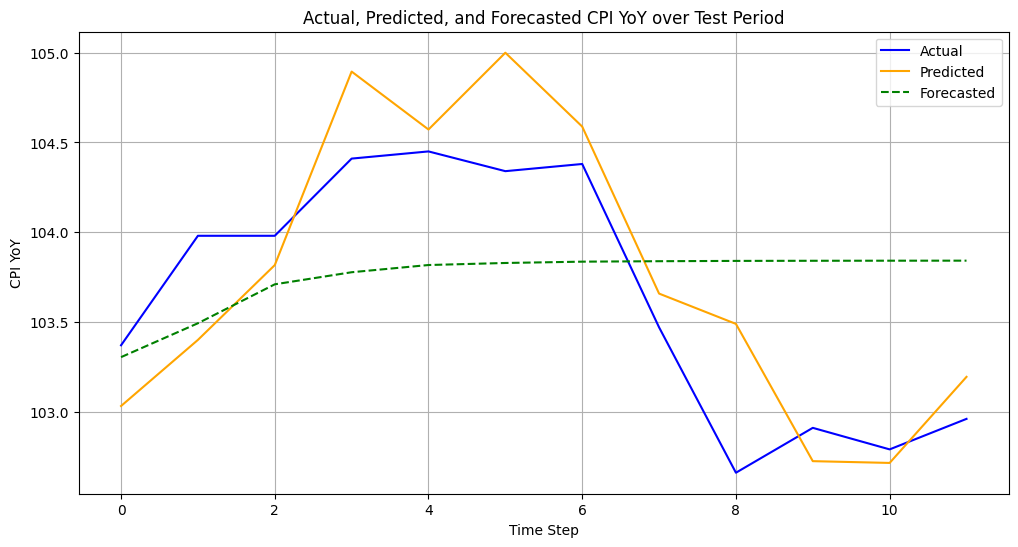

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, median_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

class LSTMForecaster:
    def __init__(self, data_path, target_col, lags=list(range(1,13)), timesteps=3):
        self.data_path = data_path
        self.target_col = target_col
        self.lags = lags
        self.timesteps = timesteps
        self.df = None
        self.scaler = StandardScaler()
        self.model = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.predictions = None

    def load_data(self):
        try:
            self.df = pd.read_csv(self.data_path, parse_dates=['time'], index_col='time')
            self.df[self.target_col] = self.scaler.fit_transform(self.df[[self.target_col]])
            for lag in self.lags:
                self.df[f'lag_{lag}'] = self.df[self.target_col].shift(lag)
            self.df = self.df.dropna()
        except FileNotFoundError:
            print(f"Error: File {self.data_path} not found")
            raise
        except KeyError:
            print(f"Error: Column 'time' or '{self.target_col}' not found in the data")
            raise

    def prepare_data(self, test_size=12):
        features = self.df[[f'lag_{lag}' for lag in self.lags]].values
        target = self.df[self.target_col].values
        X, y = [], []
        for i in range(len(features) - self.timesteps):
            X.append(features[i:i + self.timesteps])
            y.append(target[i + self.timesteps])
        X, y = np.array(X), np.array(y)
        self.X_train, self.X_test, self.y_train, self.y_test = (
            X[:-test_size], X[-test_size:], y[:-test_size], y[-test_size:]
        )
        return self.X_train, self.X_test, self.y_train, self.y_test

    def build_model(self, input_shape):
        model = Sequential([
            LSTM(64, input_shape=input_shape, activation='swish'),
            Dense(1)
        ])
        model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
        return model

    def forecast(self, steps=12, start_sequence=None):
        if self.model is None:
            raise ValueError("Model not trained. Run `run()` first.")
        if start_sequence is None:
            raise ValueError("Start sequence must be provided.")
        sequence = start_sequence.copy()
        forecasts = []
        for _ in range(steps):
            pred = self.model.predict(sequence, verbose=0)
            forecasts.append(pred[0, 0])
            # Shift the sequence and append the new prediction
            sequence = np.roll(sequence, -1, axis=1)
            sequence[:, -1, :] = pred  # Update with scaled prediction
        forecasts = np.array(forecasts)
        return self.scaler.inverse_transform(forecasts.reshape(-1, 1)).flatten()

    def plot_results(self, y_test, predictions, forecasts, test_size=12):
        plt.figure(figsize=(12, 6))
        # Plot actual test values
        plt.plot(range(test_size), y_test, label='Actual', color='blue')
        # Plot predicted test values
        plt.plot(range(test_size), predictions, label='Predicted', color='orange')
        # Plot forecasted values over test period
        plt.plot(range(test_size), forecasts, label='Forecasted', color='green', linestyle='--')
        plt.title('Actual, Predicted, and Forecasted CPI YoY over Test Period')
        plt.xlabel('Time Step')
        plt.ylabel('CPI YoY')
        plt.legend()
        plt.grid(True)
        plt.show()

    def run(self, test_size=12):
        self.load_data()
        self.X_train, self.X_test, self.y_train, self.y_test = self.prepare_data(test_size)
        self.model = self.build_model((self.X_train.shape[1], self.X_train.shape[2]))
        self.model.fit(self.X_train, self.y_train, epochs=50, batch_size=16, verbose=0)
        self.predictions = self.model.predict(self.X_test, verbose=0).flatten()
        predictions = self.scaler.inverse_transform(self.predictions.reshape(-1, 1)).flatten()
        y_test = self.scaler.inverse_transform(self.y_test.reshape(-1, 1)).flatten()
        # Forecast over test period starting from last training sequence
        forecasts = self.forecast(steps=test_size, start_sequence=self.X_train[-1:])
        # Evaluate predictions
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        mae = median_absolute_error(y_test, predictions)
        mape = mean_absolute_percentage_error(y_test, predictions) * 100
        print("Prediction Metrics (Test Set):")
        print(f"RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")
        # Evaluate forecasts
        mse_f = mean_squared_error(y_test, forecasts)
        rmse_f = np.sqrt(mse_f)
        mae_f = median_absolute_error(y_test, forecasts)
        mape_f = mean_absolute_percentage_error(y_test, forecasts) * 100
        print("\nForecast Metrics (Test Period):")
        print(f"RMSE: {rmse_f:.4f}, MSE: {mse_f:.4f}, MAE: {mae_f:.4f}, MAPE: {mape_f:.2f}%")
        self.plot_results(y_test, predictions, forecasts, test_size)
        return predictions, forecasts


forecaster = LSTMForecaster(data_path="data/analyzed_time_series.csv", target_col='cpi_yoy')
predictions, forecasts = forecaster.run(test_size=12)

Prediction Metrics (Test Set):
RMSE: 0.3499, MSE: 0.1224, MAE: 0.2564, MAPE: 0.28%

Forecast Metrics (Test Period):
RMSE: 0.3792, MSE: 0.1438, MAE: 0.2832, MAPE: 0.31%


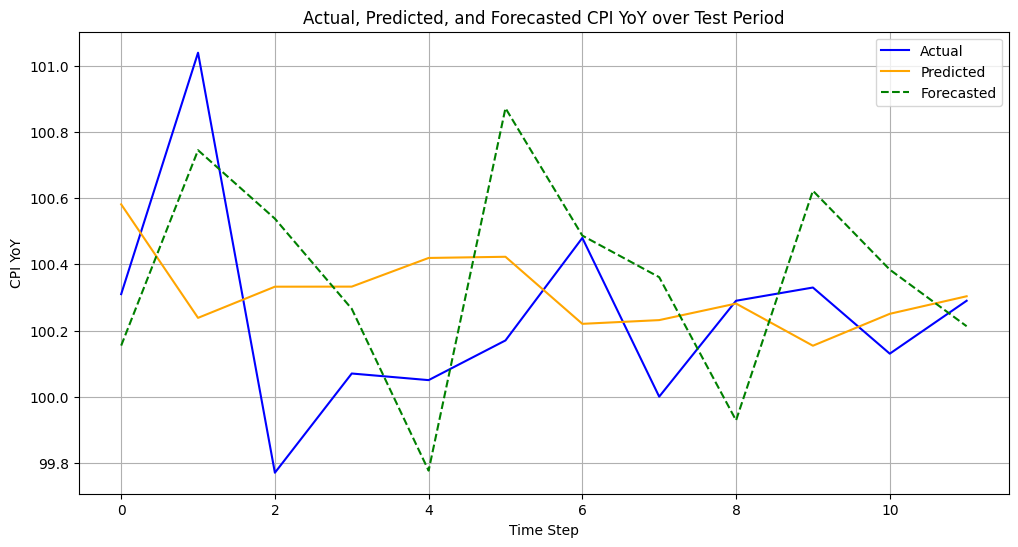

(array([100.58157 , 100.238266, 100.33251 , 100.33273 , 100.41941 ,
        100.42297 , 100.2202  , 100.23147 , 100.28149 , 100.15403 ,
        100.25051 , 100.303604], dtype=float32),
 array([100.15441 , 100.74525 , 100.53823 , 100.26558 ,  99.77628 ,
        100.87243 , 100.48697 , 100.36131 ,  99.92837 , 100.622604,
        100.38414 , 100.21293 ], dtype=float32))

In [25]:
# Sử dụng
forecaster = LSTMForecaster(data_path="data/analyzed_time_series.csv", target_col='cpi_mom')
forecaster.run()


Prediction Metrics (Test Set):
RMSE: 0.4510, MSE: 0.2034, MAE: 0.2827, MAPE: 0.31%

Forecast Metrics (Test Period):
RMSE: 1.1317, MSE: 1.2807, MAE: 0.8731, MAPE: 0.90%


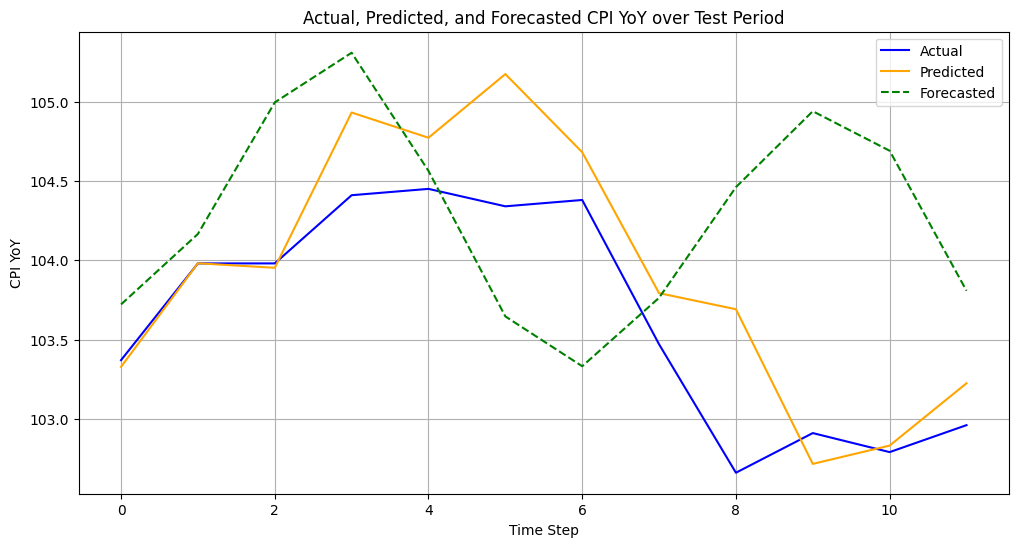

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, median_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam

class GRUForecaster:
    def __init__(self, data_path, target_col, lags=list(range(1,13)), timesteps=3):
        self.data_path = data_path
        self.target_col = target_col
        self.lags = lags
        self.timesteps = timesteps
        self.df = None
        self.scaler = StandardScaler()
        self.model = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.predictions = None

    def load_data(self):
        try:
            self.df = pd.read_csv(self.data_path, parse_dates=['time'], index_col='time')
            self.df[self.target_col] = self.scaler.fit_transform(self.df[[self.target_col]])
            for lag in self.lags:
                self.df[f'lag_{lag}'] = self.df[self.target_col].shift(lag)
            self.df = self.df.dropna()
        except FileNotFoundError:
            print(f"Error: File {self.data_path} not found")
            raise
        except KeyError:
            print(f"Error: Column 'time' or '{self.target_col}' not found in the data")
            raise

    def prepare_data(self, test_size=12):
        features = self.df[[f'lag_{lag}' for lag in self.lags]].values
        target = self.df[self.target_col].values
        X, y = [], []
        for i in range(len(features) - self.timesteps):
            X.append(features[i:i + self.timesteps])
            y.append(target[i + self.timesteps])
        X, y = np.array(X), np.array(y)
        self.X_train, self.X_test, self.y_train, self.y_test = (
            X[:-test_size], X[-test_size:], y[:-test_size], y[-test_size:]
        )
        return self.X_train, self.X_test, self.y_train, self.y_test

    def build_model(self, input_shape):
        model = Sequential([
            GRU(64, input_shape=input_shape, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
        return model

    def forecast(self, steps=12, start_sequence=None):
        if self.model is None:
            raise ValueError("Model not trained. Run `run()` first.")
        if start_sequence is None:
            raise ValueError("Start sequence must be provided.")
        sequence = start_sequence.copy()
        forecasts = []
        for _ in range(steps):
            pred = self.model.predict(sequence, verbose=0)
            forecasts.append(pred[0, 0])
            # Shift the sequence and append the new prediction
            sequence = np.roll(sequence, -1, axis=1)
            sequence[:, -1, :] = pred  # Update with scaled prediction
        forecasts = np.array(forecasts)
        return self.scaler.inverse_transform(forecasts.reshape(-1, 1)).flatten()

    def plot_results(self, y_test, predictions, forecasts, test_size=12):
        plt.figure(figsize=(12, 6))
        # Plot actual test values
        plt.plot(range(test_size), y_test, label='Actual', color='blue')
        # Plot predicted test values
        plt.plot(range(test_size), predictions, label='Predicted', color='orange')
        # Plot forecasted values over test period
        plt.plot(range(test_size), forecasts, label='Forecasted', color='green', linestyle='--')
        plt.title('Actual, Predicted, and Forecasted CPI YoY over Test Period')
        plt.xlabel('Time Step')
        plt.ylabel('CPI YoY')
        plt.legend()
        plt.grid(True)
        plt.show()

    def run(self, test_size=12):
        self.load_data()
        self.X_train, self.X_test, self.y_train, self.y_test = self.prepare_data(test_size)
        self.model = self.build_model((self.X_train.shape[1], self.X_train.shape[2]))
        self.model.fit(self.X_train, self.y_train, epochs=50, batch_size=16, verbose=0)
        self.predictions = self.model.predict(self.X_test, verbose=0).flatten()
        predictions = self.scaler.inverse_transform(self.predictions.reshape(-1, 1)).flatten()
        y_test = self.scaler.inverse_transform(self.y_test.reshape(-1, 1)).flatten()
        # Forecast over test period starting from last training sequence
        forecasts = self.forecast(steps=test_size, start_sequence=self.X_train[-1:])
        # Evaluate predictions
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        mae = median_absolute_error(y_test, predictions)
        mape = mean_absolute_percentage_error(y_test, predictions) * 100
        print("Prediction Metrics (Test Set):")
        print(f"RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")
        # Evaluate forecasts
        mse_f = mean_squared_error(y_test, forecasts)
        rmse_f = np.sqrt(mse_f)
        mae_f = median_absolute_error(y_test, forecasts)
        mape_f = mean_absolute_percentage_error(y_test, forecasts) * 100
        print("\nForecast Metrics (Test Period):")
        print(f"RMSE: {rmse_f:.4f}, MSE: {mse_f:.4f}, MAE: {mae_f:.4f}, MAPE: {mape_f:.2f}%")
        self.plot_results(y_test, predictions, forecasts, test_size)
        return predictions, forecasts

# Usage
if __name__ == "__main__":
    forecaster = GRUForecaster(data_path="data/analyzed_time_series.csv", target_col='cpi_yoy')
    predictions, forecasts = forecaster.run(test_size=12)

Prediction Metrics (Test Set):
RMSE: 0.3908, MSE: 0.1527, MAE: 0.2857, MAPE: 0.32%

Forecast Metrics (Test Period):
RMSE: 0.3674, MSE: 0.1350, MAE: 0.1731, MAPE: 0.25%


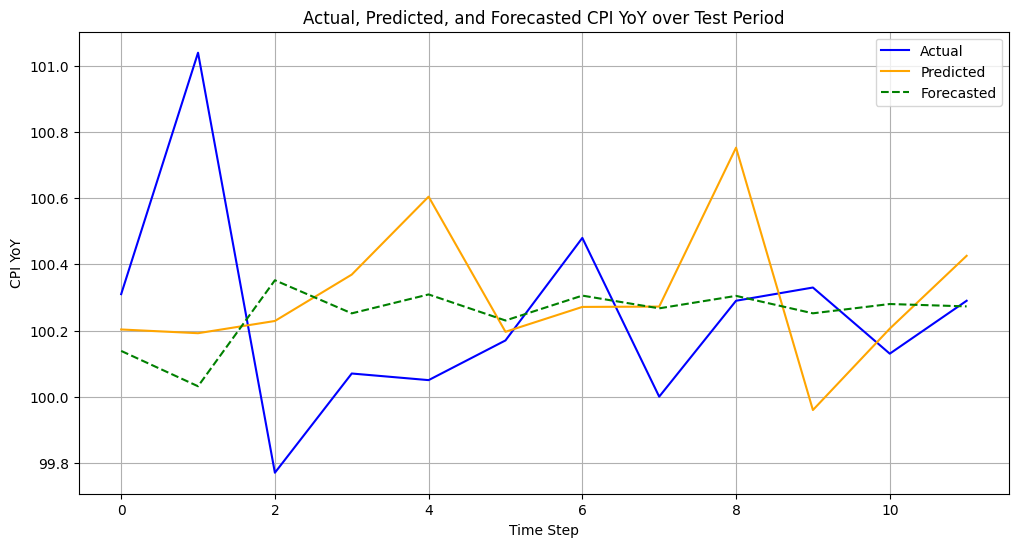

(array([100.20314 , 100.19187 , 100.22884 , 100.369125, 100.60479 ,
        100.19617 , 100.27135 , 100.27234 , 100.752945,  99.95954 ,
        100.20564 , 100.4259  ], dtype=float32),
 array([100.13832 , 100.031456, 100.35198 , 100.25191 , 100.30907 ,
        100.230316, 100.30556 , 100.267075, 100.30477 , 100.252014,
        100.28012 , 100.272964], dtype=float32))

In [27]:
forecaster = GRUForecaster(data_path="data/analyzed_time_series.csv", target_col='cpi_mom')
forecaster.run()

Prediction Metrics (Test Set):
RMSE: 0.6050, MSE: 0.3661, MAE: 0.4272, MAPE: 0.48%

Forecast Metrics (Test Period):
RMSE: 0.8452, MSE: 0.7144, MAE: 0.5859, MAPE: 0.74%


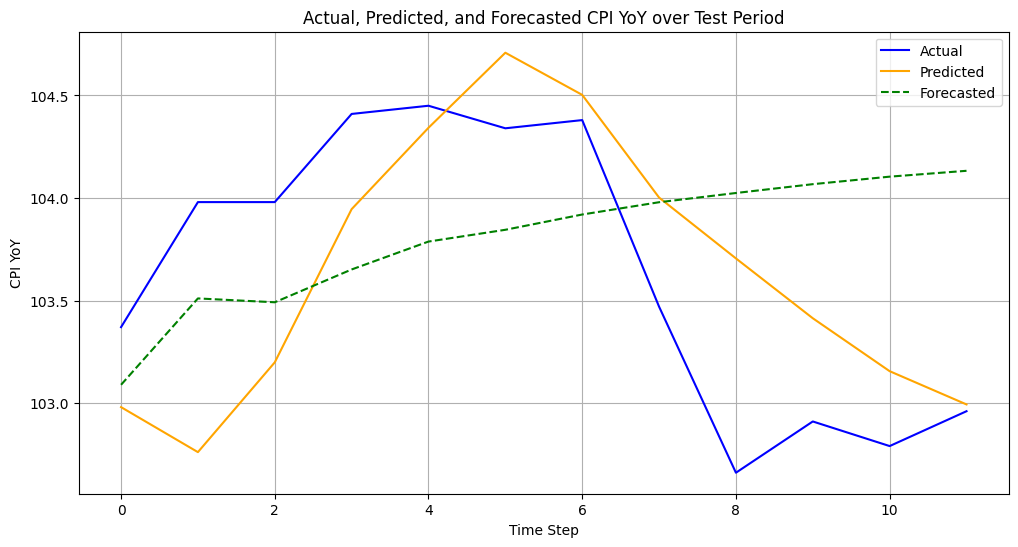

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, median_absolute_error
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

class TransformerForecaster:
    def __init__(self, data_path, target_col, lags=list(range(1,13)), timesteps=3):
        self.data_path = data_path
        self.target_col = target_col
        self.lags = lags
        self.timesteps = timesteps
        self.df = None
        self.scaler = StandardScaler()
        self.model = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.predictions = None

    def load_data(self):
        try:
            self.df = pd.read_csv(self.data_path, parse_dates=['time'], index_col='time')
            self.df[self.target_col] = self.scaler.fit_transform(self.df[[self.target_col]])
            for lag in self.lags:
                self.df[f'lag_{lag}'] = self.df[self.target_col].shift(lag)
            self.df = self.df.dropna()
        except FileNotFoundError:
            print(f"Error: File {self.data_path} not found")
            raise
        except KeyError:
            print(f"Error: Column 'time' or '{self.target_col}' not found in the data")
            raise

    def prepare_data(self, test_size=12):
        features = self.df[[f'lag_{lag}' for lag in self.lags]].values
        target = self.df[self.target_col].values
        X, y = [], []
        for i in range(len(features) - self.timesteps):
            X.append(features[i:i + self.timesteps])
            y.append(target[i + self.timesteps])
        X, y = np.array(X), np.array(y)
        self.X_train, self.X_test, self.y_train, self.y_test = (
            X[:-test_size], X[-test_size:], y[:-test_size], y[-test_size:]
        )
        return self.X_train, self.X_test, self.y_train, self.y_test

    def build_model(self, input_shape, num_heads=4, key_dim=64):
        inputs = Input(shape=input_shape)
        x = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(inputs, inputs)
        x = LayerNormalization(epsilon=1e-6)(x)
        x = Dense(64, activation='relu')(x)
        x = Dense(1)(x[:, -1, :])  # Take the last timestep
        model = Model(inputs=inputs, outputs=x)
        model.compile(optimizer=Adam(0.001), loss='mse')
        return model

    def forecast(self, steps=12, start_sequence=None):
        if self.model is None:
            raise ValueError("Model not trained. Run `run()` first.")
        if start_sequence is None:
            raise ValueError("Start sequence must be provided.")
        sequence = start_sequence.copy()
        forecasts = []
        for _ in range(steps):
            pred = self.model.predict(sequence, verbose=0)
            forecasts.append(pred[0, 0])
            # Shift the sequence and append the new prediction
            sequence = np.roll(sequence, -1, axis=1)
            sequence[:, -1, :] = pred  # Update with scaled prediction
        forecasts = np.array(forecasts)
        return self.scaler.inverse_transform(forecasts.reshape(-1, 1)).flatten()

    def plot_results(self, y_test, predictions, forecasts, test_size=12):
        plt.figure(figsize=(12, 6))
        # Plot actual test values
        plt.plot(range(test_size), y_test, label='Actual', color='blue')
        # Plot predicted test values
        plt.plot(range(test_size), predictions, label='Predicted', color='orange')
        # Plot forecasted values over test period
        plt.plot(range(test_size), forecasts, label='Forecasted', color='green', linestyle='--')
        plt.title('Actual, Predicted, and Forecasted CPI YoY over Test Period')
        plt.xlabel('Time Step')
        plt.ylabel('CPI YoY')
        plt.legend()
        plt.grid(True)
        plt.show()

    def run(self, test_size=12):
        self.load_data()
        self.X_train, self.X_test, self.y_train, self.y_test = self.prepare_data(test_size)
        self.model = self.build_model((self.X_train.shape[1], self.X_train.shape[2]), num_heads=4, key_dim=64)
        self.model.fit(self.X_train, self.y_train, epochs=50, batch_size=16, verbose=0)
        self.predictions = self.model.predict(self.X_test, verbose=0).flatten()
        predictions = self.scaler.inverse_transform(self.predictions.reshape(-1, 1)).flatten()
        y_test = self.scaler.inverse_transform(self.y_test.reshape(-1, 1)).flatten()
        # Forecast over test period starting from last training sequence
        forecasts = self.forecast(steps=test_size, start_sequence=self.X_train[-1:])
        # Evaluate predictions
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        mae = median_absolute_error(y_test, predictions)
        mape = mean_absolute_percentage_error(y_test, predictions) * 100
        print("Prediction Metrics (Test Set):")
        print(f"RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")
        # Evaluate forecasts
        mse_f = mean_squared_error(y_test, forecasts)
        rmse_f = np.sqrt(mse_f)
        mae_f = median_absolute_error(y_test, forecasts)
        mape_f = mean_absolute_percentage_error(y_test, forecasts) * 100
        print("\nForecast Metrics (Test Period):")
        print(f"RMSE: {rmse_f:.4f}, MSE: {mse_f:.4f}, MAE: {mae_f:.4f}, MAPE: {mape_f:.2f}%")
        self.plot_results(y_test, predictions, forecasts, test_size)
        return predictions, forecasts


forecaster = TransformerForecaster(data_path="data/analyzed_time_series.csv", target_col='cpi_yoy')
predictions, forecasts = forecaster.run(test_size=12)

Prediction Metrics (Test Set):
RMSE: 0.3598, MSE: 0.1294, MAE: 0.2785, MAPE: 0.30%

Forecast Metrics (Test Period):
RMSE: 0.3119, MSE: 0.0973, MAE: 0.1616, MAPE: 0.21%


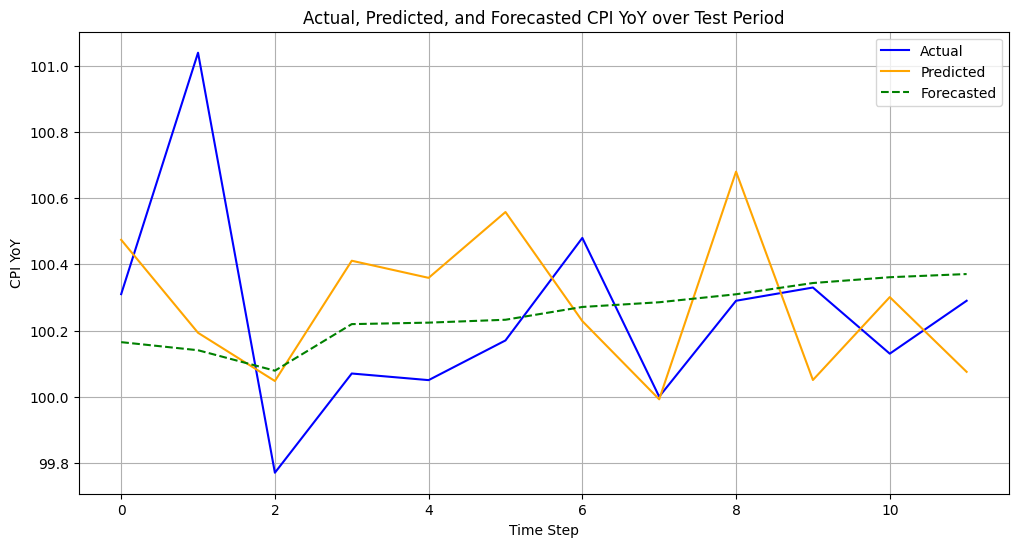

(array([100.47433 , 100.19311 , 100.04732 , 100.41102 , 100.35923 ,
        100.55833 , 100.22853 ,  99.992   , 100.680405, 100.050354,
        100.30106 , 100.07504 ], dtype=float32),
 array([100.16485 , 100.14038 , 100.078514, 100.21935 , 100.223816,
        100.23255 , 100.27123 , 100.28546 , 100.30961 , 100.34359 ,
        100.36116 , 100.370766], dtype=float32))

In [29]:
forecaster = TransformerForecaster(data_path="data/analyzed_time_series.csv", target_col='cpi_mom')
forecaster.run()


Prediction Metrics (Test Set):
RMSE: 0.7465, MSE: 0.5572, MAE: 0.5687, MAPE: 0.59%

Forecast Metrics (Test Period):
RMSE: 8.0439, MSE: 64.7037, MAE: 6.9504, MAPE: 6.68%


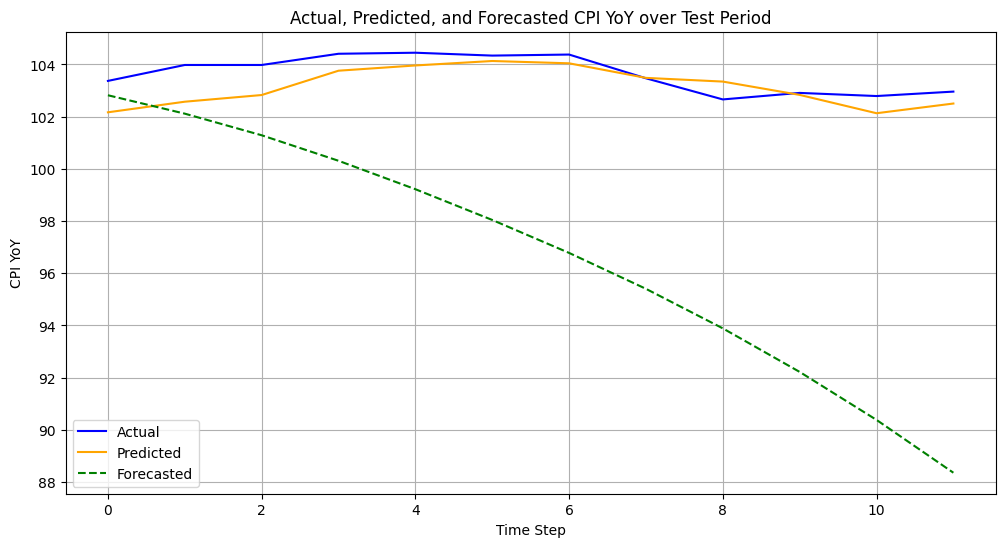

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, median_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

class MLPForecaster:
    def __init__(self, data_path, target_col, lags=list(range(1,13)), timesteps=3):
        self.data_path = data_path
        self.target_col = target_col
        self.lags = lags
        self.timesteps = timesteps
        self.df = None
        self.scaler = StandardScaler()
        self.model = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.predictions = None

    def load_data(self):
        try:
            self.df = pd.read_csv(self.data_path, parse_dates=['time'], index_col='time')
            self.df[self.target_col] = self.scaler.fit_transform(self.df[[self.target_col]])
            for lag in self.lags:
                self.df[f'lag_{lag}'] = self.df[self.target_col].shift(lag)
            self.df = self.df.dropna()
        except FileNotFoundError:
            print(f"Error: File {self.data_path} not found")
            raise
        except KeyError:
            print(f"Error: Column 'time' or '{self.target_col}' not found in the data")
            raise

    def prepare_data(self, test_size=12):
        features = self.df[[f'lag_{lag}' for lag in self.lags]].values
        target = self.df[self.target_col].values
        X, y = [], []
        for i in range(len(features) - self.timesteps):
            X.append(features[i:i + self.timesteps])
            y.append(target[i + self.timesteps])
        X, y = np.array(X), np.array(y)
        self.X_train, self.X_test, self.y_train, self.y_test = (
            X[:-test_size], X[-test_size:], y[:-test_size], y[-test_size:]
        )
        return self.X_train, self.X_test, self.y_train, self.y_test

    def build_model(self, input_shape):
        model = Sequential([
            Flatten(input_shape=input_shape),
            Dense(64, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer=Adam(0.001), loss='mse')
        return model

    def forecast(self, steps=12, start_sequence=None):
        if self.model is None:
            raise ValueError("Model not trained. Run `run()` first.")
        if start_sequence is None:
            raise ValueError("Start sequence must be provided.")
        sequence = start_sequence.copy()
        forecasts = []
        for _ in range(steps):
            pred = self.model.predict(sequence, verbose=0)
            forecasts.append(pred[0, 0])
            # Shift the sequence and append the new prediction
            sequence = np.roll(sequence, -1, axis=1)
            sequence[:, -1, :] = pred  # Update with scaled prediction
        forecasts = np.array(forecasts)
        return self.scaler.inverse_transform(forecasts.reshape(-1, 1)).flatten()

    def plot_results(self, y_test, predictions, forecasts, test_size=12):
        plt.figure(figsize=(12, 6))
        # Plot actual test values
        plt.plot(range(test_size), y_test, label='Actual', color='blue')
        # Plot predicted test values
        plt.plot(range(test_size), predictions, label='Predicted', color='orange')
        # Plot forecasted values over test period
        plt.plot(range(test_size), forecasts, label='Forecasted', color='green', linestyle='--')
        plt.title('Actual, Predicted, and Forecasted CPI YoY over Test Period')
        plt.xlabel('Time Step')
        plt.ylabel('CPI YoY')
        plt.legend()
        plt.grid(True)
        plt.show()

    def run(self, test_size=12):
        self.load_data()
        self.X_train, self.X_test, self.y_train, self.y_test = self.prepare_data(test_size)
        self.model = self.build_model((self.X_train.shape[1], self.X_train.shape[2]))
        self.model.fit(self.X_train, self.y_train, epochs=50, batch_size=16, verbose=0)
        self.predictions = self.model.predict(self.X_test, verbose=0).flatten()
        predictions = self.scaler.inverse_transform(self.predictions.reshape(-1, 1)).flatten()
        y_test = self.scaler.inverse_transform(self.y_test.reshape(-1, 1)).flatten()
        # Forecast over test period starting from last training sequence
        forecasts = self.forecast(steps=test_size, start_sequence=self.X_train[-1:])
        # Evaluate predictions
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        mae = median_absolute_error(y_test, predictions)
        mape = mean_absolute_percentage_error(y_test, predictions) * 100
        print("Prediction Metrics (Test Set):")
        print(f"RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")
        # Evaluate forecasts
        mse_f = mean_squared_error(y_test, forecasts)
        rmse_f = np.sqrt(mse_f)
        mae_f = median_absolute_error(y_test, forecasts)
        mape_f = mean_absolute_percentage_error(y_test, forecasts) * 100
        print("\nForecast Metrics (Test Period):")
        print(f"RMSE: {rmse_f:.4f}, MSE: {mse_f:.4f}, MAE: {mae_f:.4f}, MAPE: {mape_f:.2f}%")
        self.plot_results(y_test, predictions, forecasts, test_size)
        return predictions, forecasts


forecaster = MLPForecaster(data_path="data/analyzed_time_series.csv", target_col='cpi_yoy')
predictions, forecasts = forecaster.run(test_size=12)

Prediction Metrics (Test Set):
RMSE: 0.3717, MSE: 0.1381, MAE: 0.2972, MAPE: 0.30%

Forecast Metrics (Test Period):
RMSE: 0.3550, MSE: 0.1261, MAE: 0.2149, MAPE: 0.27%


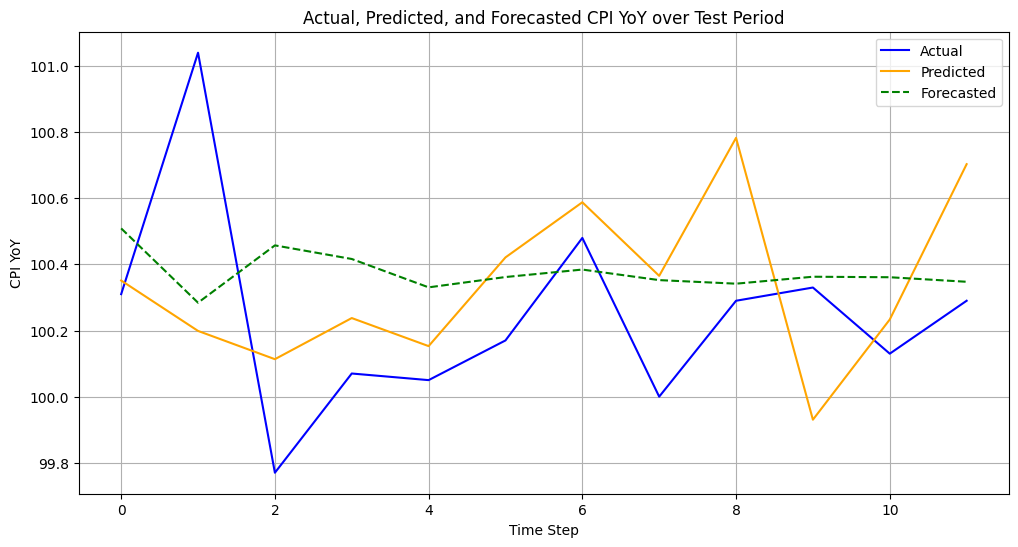

(array([100.351204, 100.19875 , 100.11333 , 100.23768 , 100.15283 ,
        100.42109 , 100.5878  , 100.3653  , 100.782585,  99.93032 ,
        100.23336 , 100.70301 ], dtype=float32),
 array([100.50878 , 100.28408 , 100.45743 , 100.41631 , 100.33052 ,
        100.36174 , 100.38433 , 100.35241 , 100.34162 , 100.36265 ,
        100.361115, 100.347374], dtype=float32))

In [31]:
forecaster = MLPForecaster(data_path="data/analyzed_time_series.csv", target_col='cpi_mom')
forecaster.run()

Prediction Metrics (Test Set):
RMSE: 0.5498, MSE: 0.3023, MAE: 0.3239, MAPE: 0.40%

Forecast Metrics (Test Period):
RMSE: 0.8509, MSE: 0.7240, MAE: 0.2539, MAPE: 0.59%


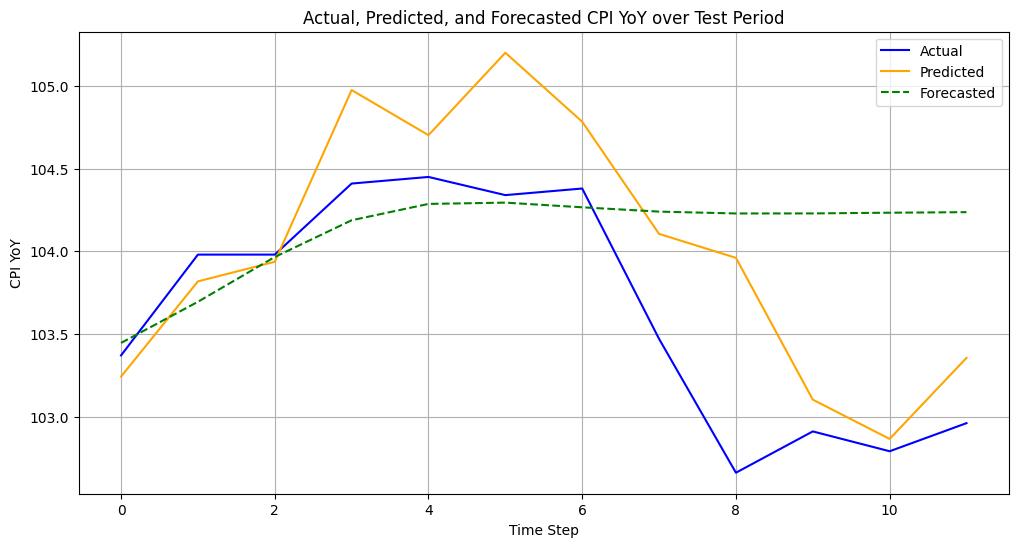

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, median_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv1D, LSTM, Dense, Flatten
from tensorflow.keras.optimizers import Adam

class CNNLSTMForecaster:
    def __init__(self, data_path, target_col, lags=list(range(1,13)), timesteps=3):
        self.data_path = data_path
        self.target_col = target_col
        self.lags = lags
        self.timesteps = timesteps
        self.df = None
        self.scaler = StandardScaler()
        self.model = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.predictions = None

    def load_data(self):
        try:
            self.df = pd.read_csv(self.data_path, parse_dates=['time'], index_col='time')
            self.df[self.target_col] = self.scaler.fit_transform(self.df[[self.target_col]])
            for lag in self.lags:
                self.df[f'lag_{lag}'] = self.df[self.target_col].shift(lag)
            self.df = self.df.dropna()
        except FileNotFoundError:
            print(f"Error: File {self.data_path} not found")
            raise
        except KeyError:
            print(f"Error: Column 'time' or '{self.target_col}' not found in the data")
            raise

    def prepare_data(self, test_size=12):
        features = self.df[[f'lag_{lag}' for lag in self.lags]].values
        target = self.df[self.target_col].values
        X, y = [], []
        for i in range(len(features) - self.timesteps):
            X.append(features[i:i + self.timesteps])
            y.append(target[i + self.timesteps])
        X, y = np.array(X), np.array(y)
        # Reshape X to (samples, timesteps, features, 1) for Conv1D
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
        self.X_train, self.X_test, self.y_train, self.y_test = (
            X[:-test_size], X[-test_size:], y[:-test_size], y[-test_size:]
        )
        return self.X_train, self.X_test, self.y_train, self.y_test

    def build_model(self, input_shape):
        model = Sequential([
            # Input shape: (timesteps, features, channels)
            TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), 
                           input_shape=(input_shape[1], input_shape[2], 1)),
            TimeDistributed(Flatten()),
            LSTM(50, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer=Adam(0.001), loss='mse')
        return model

    def forecast(self, steps=12, start_sequence=None):
        if self.model is None:
            raise ValueError("Model not trained. Run `run()` first.")
        if start_sequence is None:
            raise ValueError("Start sequence must be provided.")
        sequence = start_sequence.copy()
        forecasts = []
        for _ in range(steps):
            pred = self.model.predict(sequence, verbose=0)
            forecasts.append(pred[0, 0])
            # Shift the sequence and append the new prediction
            sequence = np.roll(sequence, -1, axis=1)
            sequence[:, -1, :, 0] = pred  # Update with scaled prediction in channel dimension
        forecasts = np.array(forecasts)
        return self.scaler.inverse_transform(forecasts.reshape(-1, 1)).flatten()

    def plot_results(self, y_test, predictions, forecasts, test_size=12):
        plt.figure(figsize=(12, 6))
        # Plot actual test values
        plt.plot(range(test_size), y_test, label='Actual', color='blue')
        # Plot predicted test values
        plt.plot(range(test_size), predictions, label='Predicted', color='orange')
        # Plot forecasted values over test period
        plt.plot(range(test_size), forecasts, label='Forecasted', color='green', linestyle='--')
        plt.title('Actual, Predicted, and Forecasted CPI YoY over Test Period')
        plt.xlabel('Time Step')
        plt.ylabel('CPI YoY')
        plt.legend()
        plt.grid(True)
        plt.show()

    def run(self, test_size=12):
        self.load_data()
        self.X_train, self.X_test, self.y_train, self.y_test = self.prepare_data(test_size)
        self.model = self.build_model(self.X_train.shape)
        self.model.fit(self.X_train, self.y_train, epochs=50, batch_size=16, verbose=0)
        self.predictions = self.model.predict(self.X_test, verbose=0).flatten()
        predictions = self.scaler.inverse_transform(self.predictions.reshape(-1, 1)).flatten()
        y_test = self.scaler.inverse_transform(self.y_test.reshape(-1, 1)).flatten()
        # Forecast over test period starting from last training sequence
        forecasts = self.forecast(steps=test_size, start_sequence=self.X_train[-1:])
        # Evaluate predictions
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        mae = median_absolute_error(y_test, predictions)
        mape = mean_absolute_percentage_error(y_test, predictions) * 100
        print("Prediction Metrics (Test Set):")
        print(f"RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")
        # Evaluate forecasts
        mse_f = mean_squared_error(y_test, forecasts)
        rmse_f = np.sqrt(mse_f)
        mae_f = median_absolute_error(y_test, forecasts)
        mape_f = mean_absolute_percentage_error(y_test, forecasts) * 100
        print("\nForecast Metrics (Test Period):")
        print(f"RMSE: {rmse_f:.4f}, MSE: {mse_f:.4f}, MAE: {mae_f:.4f}, MAPE: {mape_f:.2f}%")
        self.plot_results(y_test, predictions, forecasts, test_size)
        return predictions, forecasts


forecaster = CNNLSTMForecaster(data_path="data/analyzed_time_series.csv", target_col='cpi_yoy')
predictions, forecasts = forecaster.run(test_size=12)

Prediction Metrics (Test Set):
RMSE: 0.3955, MSE: 0.1564, MAE: 0.2720, MAPE: 0.33%

Forecast Metrics (Test Period):
RMSE: 0.3929, MSE: 0.1544, MAE: 0.1386, MAPE: 0.26%


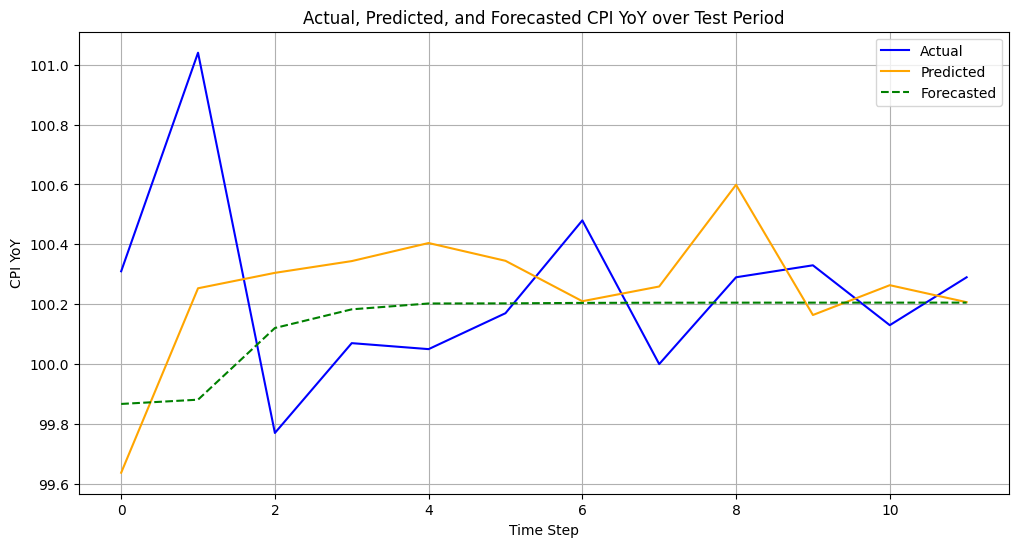

(array([ 99.63721 , 100.25326 , 100.30477 , 100.344055, 100.40436 ,
        100.34499 , 100.210014, 100.25918 , 100.59891 , 100.16398 ,
        100.26354 , 100.20679 ], dtype=float32),
 array([ 99.86692 ,  99.88116 , 100.120544, 100.18291 , 100.202446,
        100.20283 , 100.20444 , 100.20502 , 100.20521 , 100.20529 ,
        100.20532 , 100.20534 ], dtype=float32))

In [35]:
forecaster = CNNLSTMForecaster(data_path="data/analyzed_time_series.csv", target_col='cpi_mom')
forecaster.run()